In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold

import time

In [2]:
cars_df = pd.read_csv("data/car_evaluation.csv", names = ["buying","maint", "doors", "persons", "lug_boot","safety","class"])
cars_df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [3]:
cleanup_nums = {"class":     {"unacc": 4, "acc": 3,'good': 2,'vgood':1}
                }
cars_df.replace(cleanup_nums,inplace = True)
target = cars_df['class']

In [4]:
cars_df.drop( ['class'],axis = 1,inplace = True)
cars_df_categorical = pd.get_dummies(cars_df)
cars_df_categorical.head()

,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
0,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,1,0
1,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,1
2,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,1,0,0
3,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
4,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1


In [5]:
X_train,X_test,Y_train,Y_test = train_test_split(cars_df_categorical, target, random_state=42)

In [6]:
print(len(X_train))
print(len(Y_train))
print(len(X_test))
print(len(Y_test))

1296
1296
432
432


In [7]:
target.value_counts()

4    1210
3     384
2      69
1      65
Name: class, dtype: int64

In [8]:
sc=StandardScaler()
sc.fit(X_train)
X_train_std=sc.transform(X_train)
X_test_std=sc.transform(X_test)

/Users/harshsikka/opt/anaconda3/envs/CS-7641-A1/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/harshsikka/opt/anaconda3/envs/CS-7641-A1/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/harshsikka/opt/anaconda3/envs/CS-7641-A1/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


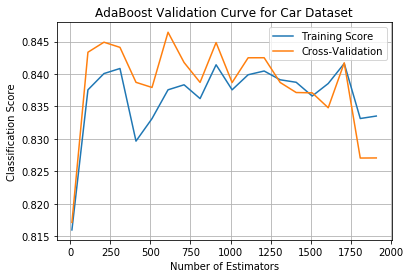

In [12]:
from sklearn import tree
boosted_classifier = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=1, min_samples_leaf=1, random_state=42), n_estimators=1500, random_state=42)
train_scores, test_scores = validation_curve(boosted_classifier, X_train, Y_train, param_name="n_estimators", param_range=np.arange(10,2000,100), cv=5,
                                            n_jobs=4)

avg_train_score, avg_test_score = np.mean(train_scores, axis=1), np.mean(test_scores, axis=1)
plt.figure()
plt.plot(np.arange(10,2000,100), avg_train_score, label='Training Score')
plt.plot(np.arange(10,2000,100), avg_test_score, label='Cross-Validation')


plt.title('AdaBoost Validation Curve for Car Dataset')
plt.xlabel('Number of Estimators')
plt.ylabel("Classification Score")
plt.legend()
plt.grid()
plt.show()

In [14]:
best_boosted_classifier = GridSearchCV(boosted_classifier, param_grid={'n_estimators' : np.arange(100,300,5)}, cv=5, n_jobs=4)
train_t0 = time.time()
best_boosted_classifier.fit(X_train, Y_train)
train_t1 = time.time()
t0 = time.time()
prediction = best_boosted_classifier.predict(X_test)
t1 = time.time()

print('Train Time: ', train_t1 - train_t0)
print('Test Time: ', t1 - t0)
print('Top Accuracy:', (accuracy_score(Y_test, prediction) * 100))
print('Top params: ', best_boosted_classifier.best_params_)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, prediction))

Train Time:  15.122967958450317
Test Time:  0.015382051467895508
Top Accuracy: 83.56481481481481
Top params:  {'n_estimators': 120}
[[ 20   0   0   0]
 [  2  13   0   0]
 [  3   7  43  50]
 [  0   0   9 285]]


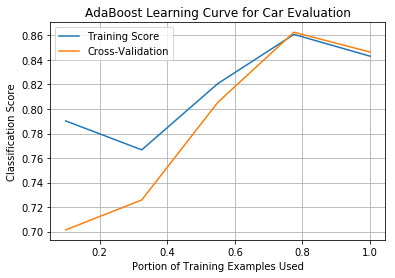

In [15]:
train_sizes, train_scores, test_scores = learning_curve(best_boosted_classifier, X_train, Y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=5, n_jobs=4)
avg_train_score, avg_test_score = np.mean(train_scores, axis=1), np.mean(test_scores, axis=1)
plt.figure()
plt.plot(train_sizes/train_sizes[-1], avg_train_score, label='Training Score')
plt.plot(train_sizes/train_sizes[-1], avg_test_score, label='Cross-Validation')
plt.title('AdaBoost Learning Curve for Car Evaluation')
plt.xlabel('Portion of Training Examples Used')
plt.ylabel("Classification Score")
plt.legend()
plt.grid()
plt.show()